In [2]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import lmdb
from pylab import *
from IPython.display import HTML
from random import shuffle
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # Smol images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [3]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '/opt/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe


In [4]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [27]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [28]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [29]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(20, # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

(3, 3, 227, 227)

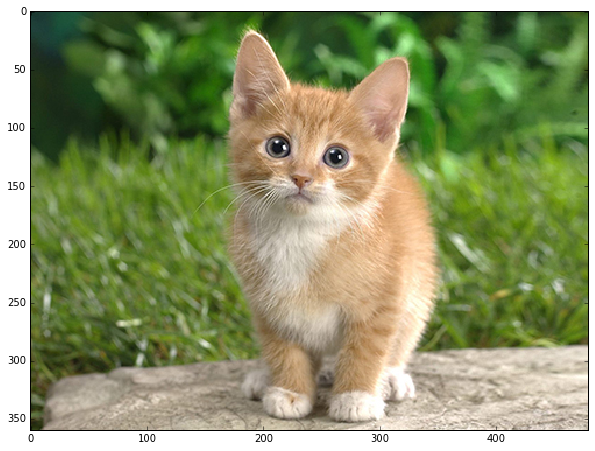

In [30]:

image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
image1 = caffe.io.load_image('/home/user/puppy1.jpg')
image2 = caffe.io.load_image('/home/user/puppy2.jpg')
transformed_image = transformer.preprocess('data', image2)
plt.imshow(image)

images = np.array([transformer.preprocess('data', x) for x in [image1, image2, image]])
images.shape

In [21]:
%%time
# copy the image data into the memory allocated for the net
#net.blobs['data'].data[...] = images
#net.blobs['data'] = images
net.blobs['data'].data[0] = images[0]
net.blobs['data'].data[1] = images[1]
net.blobs['data'].data[2] = images[2]


### perform classification
output = net.forward()

output_prob = output['prob'][0].argmax()  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob

predicted class is: 162
CPU times: user 396 ms, sys: 0 ns, total: 396 ms
Wall time: 395 ms


In [22]:
[k.argmax() for k in output['prob']]

[162, 162, 281]

In [23]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[[k.argmax() for k in output['prob']][-1]]

output label: n02123045 tabby, tabby cat


In [39]:
%%time 
start_img = image1
end_img = image2
target_class = 162 # Beagles!
cur_img = start_img.copy()
img_sequence = [cur_img]
iteration = 0

while any(cur_img != end_img):
    differences = []
    for x in xrange(227):
        for y in xrange(227):
            if any(cur_img[x][y] != end_img[x][y]):
                differences.append((x,y))

    shuffle(differences)
    iteration += 1
    print("Iteration %d, found %d differences" % (iteration ,len(differences)))
    eggs = []
    good_eggs = []
    for i, (x, y) in enumerate(differences[:20]):
        test_img = cur_img.copy()
        test_img[x][y] = end_img[x][y]
        eggs.append(test_img)
        transformed = transformer.preprocess('data', test_img)
        net.blobs['data'].data[i] = transformed
    
    output = net.forward()
    
    for egg, problayer in zip(eggs, output['prob']):
        if problayer.argmax() == target_class:
            good_eggs.append((problayer.max(), egg))
    
    if not good_eggs:
        print("Couldn't move forwards")
        break
    cur_img = max(good_eggs, key=lambda x:x[:1])[1]
    img_sequence.append(cur_img)
    if iteration > 100:
        break

Iteration 1, found 51529 differences
Iteration 2, found 51528 differences
Iteration 3, found 51527 differences
Iteration 4, found 51526 differences
Iteration 5, found 51525 differences
Iteration 6, found 51524 differences
Iteration 7, found 51523 differences
Iteration 8, found 51522 differences
Iteration 9, found 51521 differences
Iteration 10, found 51520 differences
Iteration 11, found 51519 differences
Iteration 12, found 51518 differences
Iteration 13, found 51517 differences
Iteration 14, found 51516 differences
Iteration 15, found 51515 differences
Iteration 16, found 51514 differences
Iteration 17, found 51513 differences
Iteration 18, found 51512 differences
Iteration 19, found 51511 differences
Iteration 20, found 51510 differences
Iteration 21, found 51509 differences
Iteration 22, found 51508 differences
Iteration 23, found 51507 differences
Iteration 24, found 51506 differences
Iteration 25, found 51505 differences
Iteration 26, found 51504 differences
Iteration 27, found 5

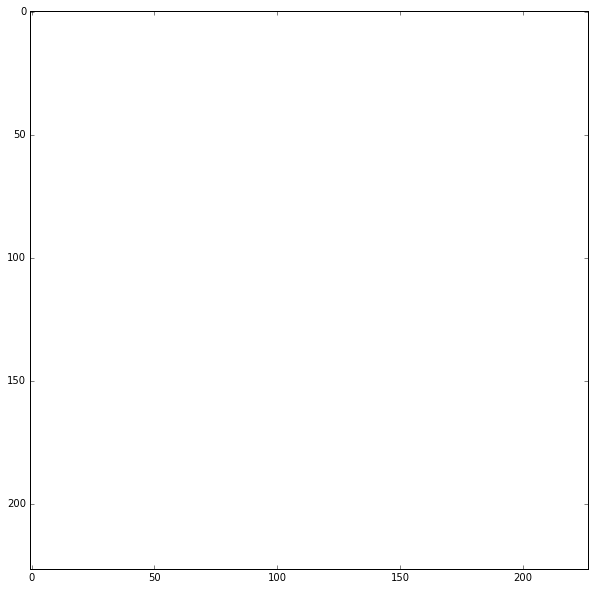

In [34]:
fig = figure(figsize=(10, 10))
ims = [(imshow(img, cmap='gray'),) for img in img_sequence]
im_ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

In [35]:
HTML(im_ani.to_html5_video())